#  Pneumonia Classification
## Slim Borchani

Nous étudions dans ce kernel, si à partir d'une image de radiologie, nous arrivons à detecter si un patient est atteint d'une pneumonie ou non.

Il s'agit d'un problème de classification classique, sur un dataset possèdant une désequilibre sur certaines classes.
La majoritée des photos que l'on possède sont des images de radio de patients possèdant une pneumonie.

## Import

In [1]:
import os

import numpy as np
import pandas as pd 
import imageio
import random as rdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
import scipy.ndimage as ndi

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

from collections import Counter, OrderedDict
import itertools  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score

Using TensorFlow backend.


## Define paths

Path pour accéder à la donnée

In [2]:
dirname = 'chest_xray/'
train_path = os.path.join(dirname, 'chest_xray/train')
train_nrml_pth = os.path.join(train_path, 'NORMAL')
train_pnm_pth = os.path.join(train_path, 'PNEUMONIA')
test_path = os.path.join(dirname, 'chest_xray/test')
test_nrml_pth = os.path.join(test_path, 'NORMAL')
test_pnm_pth = os.path.join(test_path, 'PNEUMONIA')
val_path = os.path.join(dirname, 'chest_xray/val')
val_nrml_pth = os.path.join(val_path, 'NORMAL')
val_pnm_pth = os.path.join(val_path, 'PNEUMONIA')

## Plotting image

In [3]:
#Fonction de plot permettant de visualiser les images se trouvant dans le repertoire donné en paramètre.
def plot_imgs(item_dir, num_imgs=25):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(20, 20))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        #print(img.shape)
        plt.imshow(img, cmap='gray')

    plt.tight_layout()

### Healthy people

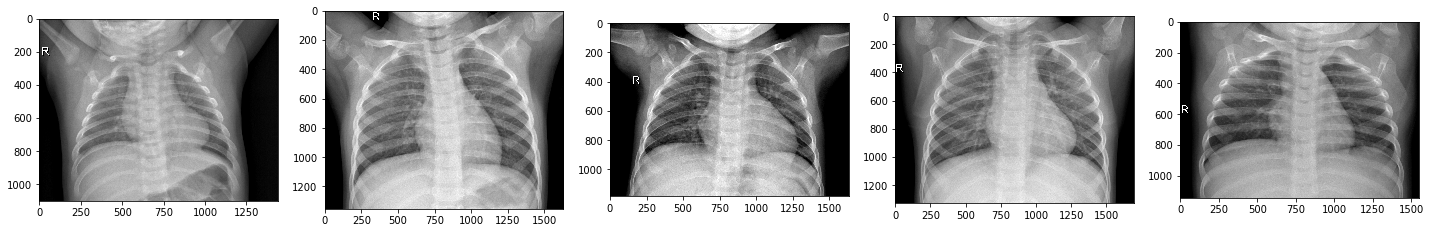

In [4]:
plot_imgs(train_nrml_pth, 5)

Exemple de patients sains

### People with pnemonia

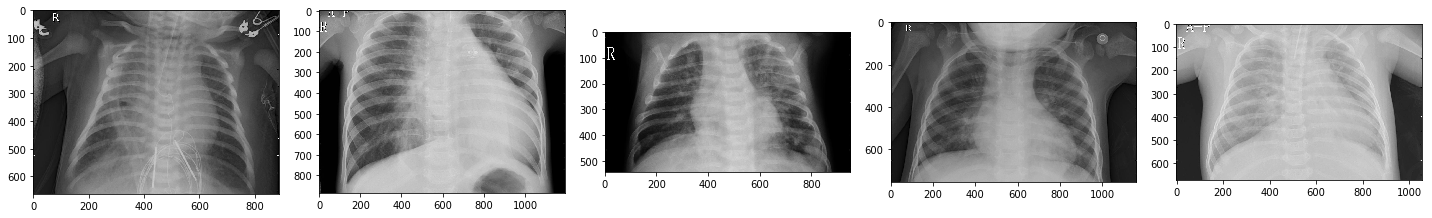

In [5]:
plot_imgs(train_pnm_pth, 5)

Exemple de patients atteints de pneumonie

## Création du modèle

### Dimensions

In [6]:
# Nous formattons les images par la suite pour leur donner uen shape de (300, 300, 3)

img_size_h = 300
img_size_w = 300
nb_channel = 3

input_shape = (img_size_h, img_size_w, nb_channel) 

### Modèle

In [7]:
# Modèle extremment simpliste de convolution mais de donnant dee bons résulats
model = Sequential([
    
    Conv2D(32, (3,3), input_shape=input_shape),
    MaxPool2D((2, 2)),
    
    Conv2D(32, (3,3)),
    MaxPool2D((2, 2)),
    
    Conv2D(64, (3,3)),
    MaxPool2D((2, 2)),
    
    Conv2D(64, (3,3)),
    MaxPool2D((2, 2)),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
      
])

### Fonction de loss personnalisée pour les problème de désequilibre dans les classes

In [8]:
# focal loss 
def focal_loss(alpha=0.25,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    return focal_crossentropy

### Optimizer

In [9]:
#Sélection des paramètres pour l'optimisation du modèle
# Focal loss à la place de la binary crossentropy, si il ya un gros imbalance présent dans la donnée.

optimizer = Adam(lr = 0.0001)
model.compile(loss='binary_crossentropy', optimizer = optimizer , metrics=['accuracy'])
#model.compile(loss=focal_loss(), optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 33, 64)        36928     
__________

## Data processing / Keras Data Generator

In [10]:
#augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

#augmentation configuration we will use for validation / testing set
test_datagen = ImageDataGenerator(rescale=1. / 255)

### Récuperations des images à partir des chemins spécifiés auparavant et par le generator défini ci-dessus

In [11]:
batch_size = 16


train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size_h, img_size_w),
    batch_size=batch_size,
    class_mode='binary',
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed = 1)

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size_h, img_size_w),
    batch_size=batch_size,
    class_mode='binary',
    #subset='validation',
    color_mode='rgb',
    shuffle=True,
    seed = 1)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size_h, img_size_w),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed = 1)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Train Distribution

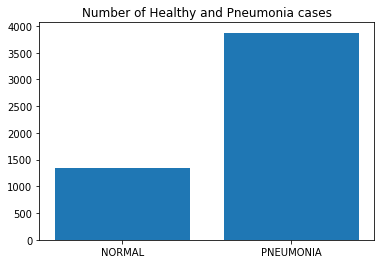

In [12]:
c = Counter(train_generator.classes)
c = OrderedDict(sorted(c.items()))


plt.bar(list(c.keys()), list(c.values()))
plt.xticks([x for x in range(2)], ['NORMAL', 'PNEUMONIA'])
plt.title("Number of Healthy and Pneumonia cases")

plt.show()

### Test Distribution

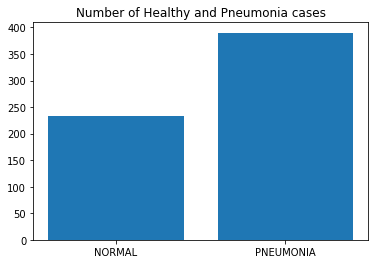

In [13]:
c = Counter(test_generator.classes)
c = OrderedDict(sorted(c.items()))


plt.bar(list(c.keys()), list(c.values()))
plt.xticks([x for x in range(2)], ['NORMAL', 'PNEUMONIA'])
plt.title("Number of Healthy and Pneumonia cases")

plt.show()

Désequilibre des classes dans le train/test set

## Hyperparamètres and Training

### Paramètre d'apprentissage

In [14]:
# Paramètre d'optimisation pour l'apprentissage

# lr reduction pour décroitre le lr, si le modèle se retrouve sur un plateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

#Early stopping si le modèle converge sur 4 iteration successive
early_stopping_monitor = EarlyStopping(patience = 4,
                                       monitor = "val_acc",
                                       mode="max",
                                       verbose = 2)

callback = [learning_rate_reduction, early_stopping_monitor]

### Fitting

In [14]:
history = model.fit_generator(
    train_generator,
    epochs = 10,
    validation_data=validation_generator,
    callbacks = callback,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_steps = validation_generator.samples // batch_size,
    )

Epoch 1/10
326/326 [==============================] - 513s 2s/step - loss: 0.3982 - acc: 0.8154 - val_loss: 0.3491 - val_acc: 0.8574
Epoch 2/10
326/326 [==============================] - 494s 2s/step - loss: 0.2582 - acc: 0.8917 - val_loss: 0.4308 - val_acc: 0.7885
Epoch 3/10
326/326 [==============================] - 491s 2s/step - loss: 0.2428 - acc: 0.9001 - val_loss: 0.3634 - val_acc: 0.8317
Epoch 4/10
326/326 [==============================] - 490s 2s/step - loss: 0.2098 - acc: 0.9204 - val_loss: 0.4506 - val_acc: 0.8045
Epoch 5/10
326/326 [==============================] - 491s 2s/step - loss: 0.1847 - acc: 0.9308 - val_loss: 0.2820 - val_acc: 0.8830
Epoch 6/10
326/326 [==============================] - 623s 2s/step - loss: 0.1739 - acc: 0.9316 - val_loss: 0.3182 - val_acc: 0.8750
Epoch 7/10
326/326 [==============================] - 757s 2s/step - loss: 0.1714 - acc: 0.9365 - val_loss: 0.3796 - val_acc: 0.8253
Epoch 8/10
326/326 [==============================] - 745s 2s/step - 

### Sauvegarde du modèle

In [15]:
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model.save('saved_model/my_modelV2') 

In [16]:
model = keras.models.load_model('saved_model/my_modelV2')

## Plots et prédiction

### Evolution du loss et de l'accuracy au cours des epochs

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

### Evaluation du modèle sur les test set

In [18]:
def get_datagenerator(generator):
    data_list = []
    data_class = []
    batch_index = 0

    while batch_index <= generator.batch_index:
        data = generator.next()
        data_list.append(data[0])
        data_class.append(data[1])
        batch_index = batch_index + 1

    # now, data_array is the numeric data of whole images
    train_data = np.concatenate(data_list)
    train_labels = np.concatenate(data_class)
    
    return train_data, train_labels

test_data, test_labels = get_datagenerator(test_generator)

In [19]:
# Evaluation on test dataset
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size = batch_size)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 16s 26ms/step
Loss on test set:  0.39263014514476824
Accuracy on test set:  0.8525641025641025


### Visualisation de la roc curve

In [20]:
# Get predictions
preds = model.predict(test_data, batch_size = batch_size)
preds = np.concatenate(preds)

In [21]:
precisions, recalls, thresholds = precision_recall_curve(test_labels, preds)
fpr, tpr, thresholds2 = roc_curve(test_labels, preds)

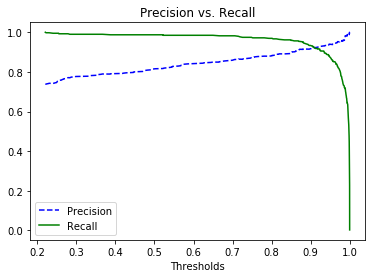

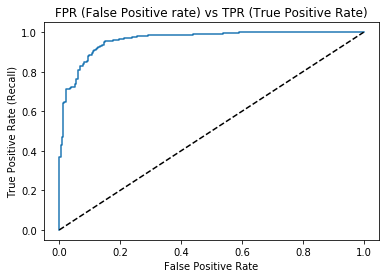

In [22]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

### Generation des classes à partir d'un threshold qui maintient la meilleur accuracy possible

In [23]:
def get_predict(preds):
    binary_predictions = []
    threshold = thresholds[np.argmax(precisions >= 0.95)]
    for i in preds:
        if i >= threshold:
            binary_predictions.append(1)
        else:
            binary_predictions.append(0) 
    return binary_predictions

binary_predictions = get_predict(preds)

### Matrice de confusions

In [24]:
# Plot non-normalized confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[217  17]
 [ 66 324]]
Normalized confusion matrix
[[0.93 0.07]
 [0.17 0.83]]


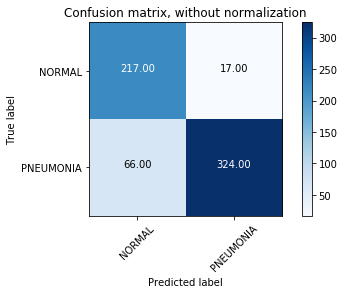

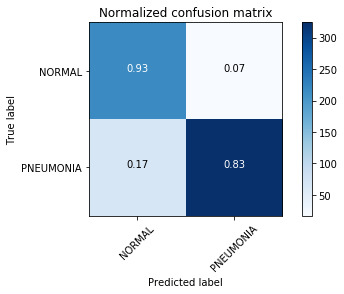

In [25]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_labels, binary_predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Visualisations du modèle sur quelques exemples

In [28]:
def recup_image_predict(k = 10):
    image_predict = []
    label_predict = []
    true_label_predict = []

    sampling_normal = rdm.sample(os.listdir(test_nrml_pth), k=k)
    sampling_pnm = rdm.sample(os.listdir(test_pnm_pth), k=k)

    for i in range(0,k):

        img_test_nrml = os.path.join(test_nrml_pth, sampling_normal[i])
        img = image.load_img(img_test_nrml, target_size=(img_size_h, img_size_w), grayscale = False)
        image_predict.append(img)
        label_predict.append(image.img_to_array(img))
        true_label_predict.append(0)

        img_test_ill = os.path.join(test_pnm_pth, sampling_pnm[i])
        img = image.load_img(img_test_ill, target_size=(img_size_h, img_size_w), grayscale = False)
        image_predict.append(img)
        label_predict.append(image.img_to_array(img) )
        true_label_predict.append(1)

    label_predict = np.asarray(label_predict)
    classes = model.predict(label_predict, batch_size=batch_size)
    classes = get_predict(classes)
    
    return image_predict, classes, true_label_predict

image_predict, classes, true_label_predict = recup_image_predict()

Nous récuperons des images aléatoirement dans nos dossiers pour essayer de les classifier.

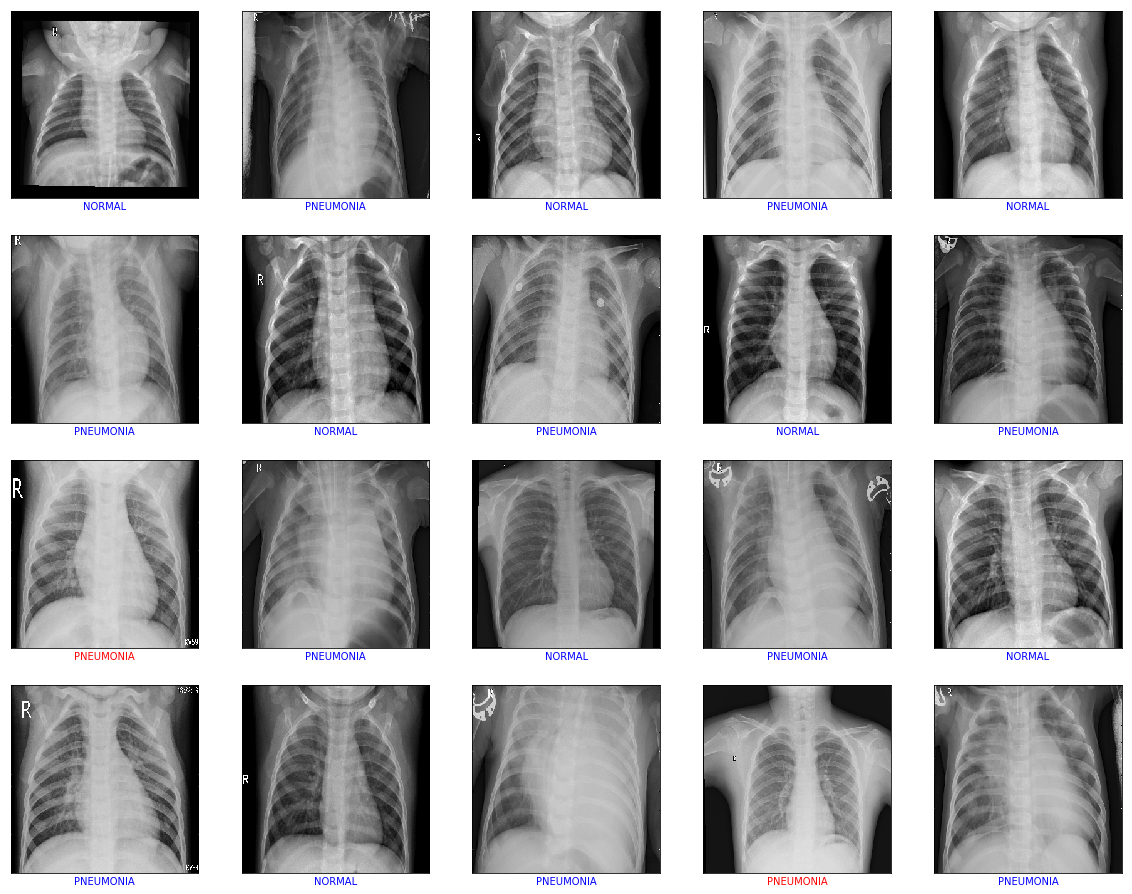

In [29]:
def plotting_afterpredict(image_predict, classes, true_label_predict):
    labels = ['NORMAL', 'PNEUMONIA']
    plt.figure(figsize=(20,20))

    for i in range(len(image_predict)):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_predict[i], cmap='gray')

        if(classes[i] == true_label_predict[i]):
            plt.xlabel(labels[classes[i]], color='blue')
        else:
            plt.xlabel(labels[classes[i]], color='red')
    plt.show()

plotting_afterpredict(image_predict, classes, true_label_predict)